# NLP PROJECT con SVM

In [ ]:
import os
import requests
import numpy as np
import pandas as pd

Descargar, guardar data y pasarla a DF

In [55]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv"

respuesta = requests.get(url)
nombre_archivo = "../data/raw/url_spam.csv"
with open(nombre_archivo, 'wb') as archivo:
    archivo.write(respuesta.content)

total_data = pd.read_csv("../data/raw/url_spam.csv")
total_data.head()

url  is_spam
0  https://briefingday.us8.list-manage.com/unsubs...     True
1                             https://www.hvper.com/     True
2                 https://briefingday.com/m/v4n3i4f3     True
3   https://briefingday.com/n/20200618/m#commentform    False
4                        https://briefingday.com/fan     True

Empezamos el procesamiento de los datos: 

Comprobar numero de entradas con cada valor 

In [56]:
print(total_data.shape)
print(f"Spam: {len(total_data.loc[total_data.is_spam == True])}")
print(f"No spam: {len(total_data.loc[total_data.is_spam == False])}")

(2999, 2)
Spam: 696
No spam: 2303


Eliminar duplicados

In [57]:
total_data = total_data.drop_duplicates()
total_data = total_data.reset_index(inplace = False, drop = True)
total_data.shape

(2369, 2)

Se han eliminado 2999-2369 = 630 registros repetidos 

Preprocesamiento del texto: elimacion de caracteres innecesarios (en este caso,"//,-,:"), elimnacion de espacios en blanco  

In [59]:
import regex as re

def preprocess_text(text):
    # Eliminar cualquier caracter que no sea una letra (a-z) o un espacio en blanco ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Eliminar espacios en blanco
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Reducir espacios en blanco múltiples a uno único
    text = re.sub(r'\s+', " ", text.lower())

    return text.split()

total_data["url"] = total_data["url"].apply(preprocess_text)
total_data.head()

url  is_spam
0  [https, briefingday, us, list, manage, com, un...     True
1                           [https, www, hvper, com]     True
2                    [https, briefingday, com, v, i]     True
3          [https, briefingday, com, m, commentform]    False
4                     [https, briefingday, com, fan]     True

Lematizacion y stopwords

In [61]:
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

total_data["url"] = total_data["url"].apply(lemmatize_text)
total_data.head(10)

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


url  is_spam
0     [http, briefingday, list, manage, unsubscribe]     True
1                                      [http, hvper]     True
2                                [http, briefingday]     True
3                   [http, briefingday, commentform]    False
4                                [http, briefingday]     True
5  [http, brookings, interactives, reopening, ame...    False
6  [http, reuters, investigates, special, report,...    False
7  [http, theatlantic, magazine, archive, superma...    False
8  [http, john, bolton, book, excerpt, trump, ukr...    False
9  [http, theguardian, travel, tourism, coronavir...    False

Nube de palabras: usamos wordcloud para mostrrar las palabras mas frecuentes 

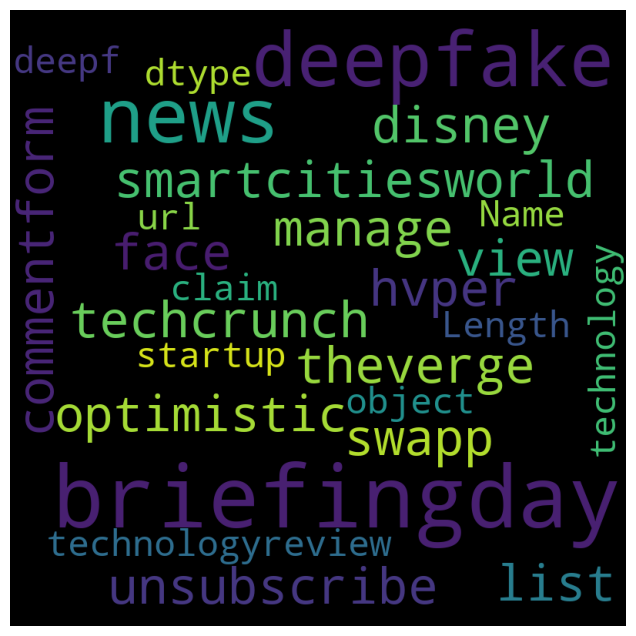

In [62]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(total_data["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

1. transformacion de categoria "is_spam" a numerica: primero cambiamos de dtype "bool" a "str". 

In [71]:
# Extraer valores únicos de la columna "is_spam"
valores_unicos = total_data["is_spam"].unique()

# Imprimir los valores únicos
print(valores_unicos)


total_data['is_spam'] = total_data['is_spam'].astype(str)

# # Convertir la variable categórica a numérica: 

total_data['is_spam'] = total_data['is_spam'].map({'True': 1, 'False': 0})
print(total_data)

['True' 'False']
                                                    url  is_spam
0        [http, briefingday, list, manage, unsubscribe]        1
1                                         [http, hvper]        1
2                                   [http, briefingday]        1
3                      [http, briefingday, commentform]        0
4                                   [http, briefingday]        1
...                                                 ...      ...
2364  [http, theverge, disney, deepfake, face, swapp...        0
2365  [http, smartcitiesworld, news, news, deepfake,...        0
2366    [http, techcrunch, optimistic, view, deepfakes]        0
2367  [http, technologyreview, startup, claim, deepf...        0
2368                           [http, news, technology]        0

[2369 rows x 2 columns]


Guardamos datos limpios en CSV

In [94]:
total_data.to_csv('../data/processed/total_data_clean.csv', index=False)

Convertimos palabras en vectores numericos

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens_list = total_data["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = total_data["is_spam"]

print(y.head(5))
X[:5]


0    1
1    1
2    1
3    0
4    1
Name: is_spam, dtype: int64


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Separar en train y test data

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Entrenamos el modelo

In [78]:
from sklearn.svm import SVC

model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

Prediccion del modelo

In [79]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Metricas: accuracy, confusion matrix y classification report

In [80]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_rep)
print('Confusion Matrix:')
print(confusion_mat)

Accuracy: 0.9514767932489452
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       435
           1       0.83      0.51      0.63        39

    accuracy                           0.95       474
   macro avg       0.90      0.75      0.80       474
weighted avg       0.95      0.95      0.95       474

Confusion Matrix:
[[431   4]
 [ 19  20]]


Graficamos la Matriz de confusion

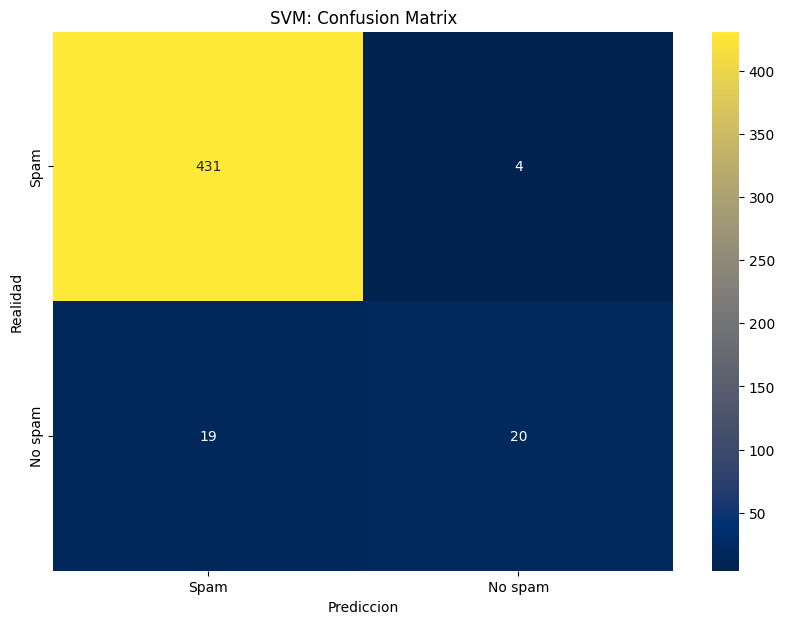

In [93]:
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='cividis', xticklabels=['Spam', 'No spam'], yticklabels=['Spam', 'No spam'])
plt.xlabel('Prediccion')
plt.ylabel('Realidad')
plt.title('SVM: Confusion Matrix')
plt.show()

95% de accuracy es un buen resultado pero tratamos de optimizar para conseguir menos falsos negativos. 
Usamos GridSearchCV para buscar lo smejores hiperparametros. 

In [97]:
from sklearn.model_selection import GridSearchCV

# Definir el modelo SVM
svm = SVC()

# Definir la grilla de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Configurar búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=1)

# Entrenar el modelo
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

y_pred = model.predict(X_test)
y_pred

# Evaluar el modelo final en el conjunto de prueba
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy:.2f}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros encontrados:
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Precisión del modelo en el conjunto de prueba: 0.96


Mejores hiperparámetros encontrados: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Se ha mejorado el modelo en un 1%. 
Guardamos el modelo. 

In [98]:
from pickle import dump

dump(model, open("../models/svm_classifier_linear_100_01_rfb_42.sav", "wb"))